In [6]:
import sqlite3
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from tqdm import tqdm
from timeit import default_timer as timer
from openpyxl import load_workbook
from sklearn.cluster import KMeans
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances
from yellowbrick.cluster import KElbowVisualizer

In [7]:
dump_path='/Users/jinbihui/Desktop/MS/834'
dump_database_name='plugin.db'


db = sqlite3.connect(os.path.join(dump_path, dump_database_name))
c = db.cursor()

In [8]:
pd.read_sql(f'SELECT category,count(id) FROM extensions group by category', con=db)
print("Total number of extensions:",len(pd.read_sql(f'SELECT id FROM extensions', con=db)))
print("Number of extensions with privacy practices adopted:",len(pd.read_sql(f'SELECT id, name, category, rate, rateCount, users, privacy, size FROM extensions where privacy != "not provided" and privacy != "None"', con=db)))
nonePP = pd.read_sql(f'SELECT id, name, category, rate, rateCount, users, privacy, size FROM extensions where privacy = "None"', con=db)
print("Number of extensions without privacy practices adopted:", len(pd.read_sql(f'SELECT id, name, category, rate, rateCount, users, privacy, size FROM extensions where privacy == "None"', con=db)))


Total number of extensions: 110240
Number of extensions with privacy practices adopted: 12423
Number of extensions without privacy practices adopted: 31908


# Clustering extensions with privacy practices adopted

## Data processing

In [9]:
def write_excel(filename,sheetname,dataframe):
    book = load_workbook(filename)
    writer = pd.ExcelWriter(filename, engine='openpyxl') 
    writer.book = book

    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    dataframe.to_excel(writer, sheetname,index=False)

    writer.save()

def user_convert(u):
    if '+' in u:
        return int(float(u.split('+')[0].strip().replace(',','')))
    else: return int(float(u.split(' ')[0].strip().replace(',','')))
def size_convert(s):
    scaler = {'KiB': 1,'MiB': 1024}
    s = re.split('([-+]?\d+\.\d+)|([-+]?\d+)',s.strip())
    s = [r.strip() for r in s if r is not None and r.strip() != '']
    return float(s[0])*scaler[s[1]]

In [8]:
rows = pd.read_sql(f'SELECT id, name, category, rate, rateCount, users, privacy, size FROM extensions where privacy != "not provided" and privacy != "None" and id not in {tuple(invaild_id2)}', con=db)
rows['users'] = rows['users'].apply(user_convert)
rows['size']=rows['size'].apply(size_convert)
for i in rows.index:
    for pp in rows.at[i, "privacy"].split(';'):
        rows.at[i, f"{pp}"] = 1
        
rows = rows.fillna(0)

dt =rows.copy()
dt.drop(['id'], axis=1, inplace=True)
dt.drop(['name'], axis=1, inplace=True)
dt.drop(['category'], axis=1, inplace=True)
dt.drop(['privacy'], axis=1, inplace=True)
dt.drop(['rate'], axis=1, inplace=True)
dt.drop(['rateCount'], axis=1, inplace=True)
dt.drop(['users'], axis=1, inplace=True)
dt.drop(['size'], axis=1, inplace=True)

c.close()
db.close()

print(dt.dtypes)
smart_array = dt.copy().values
smart_array[:,0] = smart_array[:,0].astype(str)
categorical_index = list([0])
print(categorical_index)
print(len(smart_array))
print(smart_array[0])

Location                               float64
User activity                          float64
Website content                        float64
Web history                            float64
Personally identifiable information    float64
Authentication information             float64
Personal communications                float64
Financial and payment information      float64
Health information                     float64
dtype: object
[0]
12423
[1. 1. 1. 0. 0. 0. 0. 0. 0.]


## Determining the optimal K using the Elbow method with silhouette scores

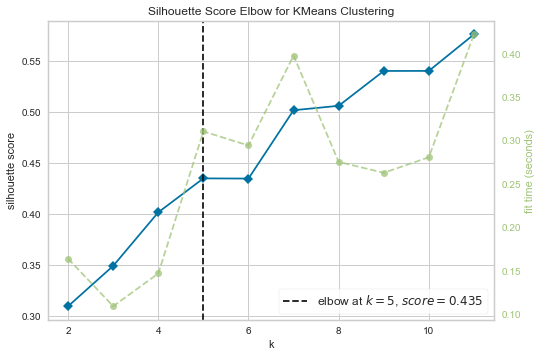

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [165]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12),metric='silhouette', n_jobs = -1) #,metric='silhouette'

visualizer.fit(smart_array)        # Fit the data to the visualizer
visualizer.show()   

## Determining K-medoids clustering algorithms

In [202]:
# We tested several algorithms and found that the algorithm 'Fast PAM' has the minimal loss value

euc = euclidean_distances(smart_array)

# fp = kmedoids.fasterpam(euc,5)
# print('FasterPAM Loss:', fp.loss)

fp1 = kmedoids.fastpam1(euc,5)
print('Fast PAM Loss:', fp1.loss)

# pam = kmedoids.pam(euc,5)
# print('pam Loss:', pam.loss)

# alt = kmedoids.alternating(euc,5)
# print('Alternating Loss:', alt.loss)

print(sorted(fp1.medoids))
pd.set_option('display.max_rows', 5000)

Fast PAM Loss: 7134.976117556513
[2, 24, 5100, 8555, 10369]


In [ ]:
dfpam = rows.copy()

dfpam['labels'] = fp1.labels
dfpam.drop(['id'], axis=1, inplace=True)
dfpam.drop(['name'], axis=1, inplace=True)
# dfpam.drop(['category'], axis=1, inplace=True)
dfpam.drop(['privacy'], axis=1, inplace=True)
dfpam.drop(['rate'], axis=1, inplace=True)
dfpam.drop(['rateCount'], axis=1, inplace=True)
dfpam.drop(['users'], axis=1, inplace=True)
dfpam.drop(['size'], axis=1, inplace=True)

pd.set_option('display.max_rows', 5000)
tmp = dfpam.groupby(dfpam.columns.tolist(),as_index=False).size()
tmp.groupby(['labels','category']).apply(lambda x: x.sample(frac=1)).head(5000)

In [245]:
dfpam = rows.copy()

dfpam['labels'] = fp1.labels
dfpam.drop(['id'], axis=1, inplace=True)
dfpam.drop(['name'], axis=1, inplace=True)
# dfpam.drop(['category'], axis=1, inplace=True)
dfpam.drop(['privacy'], axis=1, inplace=True)
dfpam.drop(['rate'], axis=1, inplace=True)
dfpam.drop(['rateCount'], axis=1, inplace=True)
dfpam.drop(['users'], axis=1, inplace=True)

dfpam.drop(['size'], axis=1, inplace=True)

first_column = dfpam.pop('labels')
dfpam.insert(0, 'labels', first_column)


pd.set_option('display.max_rows', 5000)
tmp = dfpam.groupby(dfpam.columns.tolist(),as_index=False).size()
tmp = tmp.groupby(['labels','category']).apply(lambda x: x.sample(frac=1))
tmp.to_excel('./kmedoids.xlsx',index=False,sheet_name='Sheet1')
    

dfpam = rows.copy()
dfpam['labels'] = fp1.labels
first_column = dfpam.pop('category')
dfpam.insert(0, 'category', first_column)
first_column = dfpam.pop('labels')
dfpam.insert(0, 'labels', first_column)

dfpam.drop(['size'], axis=1, inplace=True)
dfpam.drop(['privacy'], axis=1, inplace=True)

tmp = dfpam.groupby(dfpam.columns.tolist(),as_index=False).size()
tmp.drop(['size'], axis=1, inplace=True)
tmp = tmp.groupby(['labels','category']).apply(lambda x: x.sample(frac=1))
tmp.head(5000)
                        
write_excel('./kmedoids.xlsx','Sheet2',tmp)


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances,manhattan_distances
import requests

def idxByMinVal(data, subclu, ana):
        
    dist = [sum(x) for x in data]
    idxs = np.argwhere(dist == np.amin(dist))
    minIdx = {'idx':-1,'users':-1,'rate':-1.0,'rateCount':-1}
    
    for indx in idxs:
        if minIdx['users'] == subclu.iloc[indx[0]]['users']:
            if minIdx['rate'] == subclu.iloc[indx[0]]['rate']:
                if minIdx['rateCount'] == subclu.iloc[indx[0]]['rateCount']:
                    minIdx['idx'] = indx[0]
                    minIdx['users'] = subclu.iloc[indx[0]]['users']
                    minIdx['rate'] = subclu.iloc[indx[0]]['rate']
                    minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']
                    
            elif minIdx['rate'] < subclu.iloc[indx[0]]['rate']:
                minIdx['idx'] = indx[0]
                minIdx['users'] = subclu.iloc[indx[0]]['users']
                minIdx['rate'] = subclu.iloc[indx[0]]['rate']
                minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']
                
        elif minIdx['users'] < subclu.iloc[indx[0]]['users']:
            minIdx['idx'] = indx[0]
            minIdx['users'] = subclu.iloc[indx[0]]['users']
            minIdx['rate'] = subclu.iloc[indx[0]]['rate']
            minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']
    return minIdx['idx']

def get_col_name(datarow): 
    return datarow.columns[datarow.eq(1).any()].to_list()

extension = pd.DataFrame(columns=['labels','category','id','name','pp'])
b = pd.read_excel('./kmedoids.xlsx','Sheet2')

for label in b['labels'].drop_duplicates().values:
    for cate in b.loc[b['labels']==label]['category'].drop_duplicates().values:
        sublbl = b.loc[b['labels']==label]
        subclu =  sublbl.loc[sublbl['category']==cate]
        
        while True:
            idx = idxByMinVal(manhattan_distances(subclu.iloc[:,7:16].values),subclu,[label,cate])
            minSubRow = subclu.iloc[idx]
            
            rowId =minSubRow['id']
            if requests.get(f'https://chrome.google.com/webstore/detail/chegg-answers-free/{rowId}?hl=ca').status_code==200:
                subclu = subclu[subclu['id']!=rowId]
        val = pd.DataFrame({'labels':label,'category':cate,'id':minSubRow['id'],'name':minSubRow['name'],'pp':minSubRow[7:16].sum()}, index=[0])
        extension = pd.concat([extension, val], ignore_index=True, axis = 0)
        
extension.groupby(extension.columns.tolist(),as_index=False).size().drop(['size'], axis=1, inplace=True)
extension.groupby(['labels','pp']).apply(lambda x: x.sample(frac=1)).drop(['pp'], axis=1).drop(['labels'], axis=1)

extension
# extension
write_excel('./kmedoids.xlsx','extensions',extension)


In [253]:
extension = pd.read_excel('./kmedoids.xlsx',sheet_name='extensions')
    
for label in extension['labels'].drop_duplicates().values:
    for lid in extension.loc[extension['labels']==label]['id']:
        print(label, extension.loc[extension['id']==lid]['pp'],get_col_name(b[b['id']==lid].iloc[:,7:16]))
    print('\n')

0 0    1
Name: pp, dtype: int64 ['Website content']
0 1    1
Name: pp, dtype: int64 ['Website content']
0 2    1
Name: pp, dtype: int64 ['Website content']
0 3    1
Name: pp, dtype: int64 ['Website content']
0 4    1
Name: pp, dtype: int64 ['Website content']
0 5    1
Name: pp, dtype: int64 ['Website content']
0 6    1
Name: pp, dtype: int64 ['Website content']
0 7    1
Name: pp, dtype: int64 ['Website content']
0 8    1
Name: pp, dtype: int64 ['Website content']
0 9    1
Name: pp, dtype: int64 ['Website content']
0 10    1
Name: pp, dtype: int64 ['Website content']


1 11    2
Name: pp, dtype: int64 ['Personally identifiable information', 'Authentication information']
1 12    2
Name: pp, dtype: int64 ['Personally identifiable information', 'Authentication information']
1 13    2
Name: pp, dtype: int64 ['Personally identifiable information', 'Authentication information']
1 14    2
Name: pp, dtype: int64 ['Personally identifiable information', 'Authentication information']
1 15    2
Nam

## Selecting next capable extension if the one doen't meet the condition

In [ ]:
def idxByMinValExcept(data):
    # print(data)
    # print([sum(x) for x in data])
    pp = manhattan_distances(data.iloc[:,7:16].values)
    dist = [sum(x) for x in pp]
    idxs = np.argwhere(dist == np.amin(dist))
    
    subclu = data
    minIdx = {'idx':-1,'users':-1,'rate':-1.0,'rateCount':-1}
    
    for indx in idxs:
       
        rowId = subclu.iloc[indx[0]]['id']
        if rowId not in replaceId:
            if minIdx['users'] == subclu.iloc[indx[0]]['users']:
                if minIdx['rate'] == subclu.iloc[indx[0]]['rate']:
                    if minIdx['rateCount'] == subclu.iloc[indx[0]]['rateCount']:
                        minIdx['idx'] = indx[0]
                        minIdx['users'] = subclu.iloc[indx[0]]['users']
                        minIdx['rate'] = subclu.iloc[indx[0]]['rate']
                        minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']

                elif minIdx['rate'] < subclu.iloc[indx[0]]['rate']:
                    minIdx['idx'] = indx[0]
                    minIdx['users'] = subclu.iloc[indx[0]]['users']
                    minIdx['rate'] = subclu.iloc[indx[0]]['rate']
                    minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']

            elif minIdx['users'] < subclu.iloc[indx[0]]['users']:
                minIdx['idx'] = indx[0]
                minIdx['users'] = subclu.iloc[indx[0]]['users']
                minIdx['rate'] = subclu.iloc[indx[0]]['rate']
                minIdx['rateCount'] = subclu.iloc[indx[0]]['rateCount']
    return minIdx['idx']

In [ ]:
# Extension IDs that are not capable
replaceId=[
    # 'pgpidfocdapogajplhjofamgeboonmmj',
# 'iginnfkhmmfhlkagcmpgofnjhanpmklb',
# 'olimcenppncifgiahopimblidefpdffi',
# 'ncennffkjdiamlpmcbajkmaiiiddgioo',
# 'bfafldbloncllehfiaflmmjhohiobfmo',
# 'kfnalellkdfhomefgbioaflnnppackjm',
# 'laookkfknpbbblfpciffpaejjkokdgca',
# 'ieefikngalndempadapdojcmjlpocbmn',
# 'bljmbajalidimklpecpaagkgcldgahho',
# 'dapjbgnjinbpoindlpdmhochffioedbn',
# 'iolcbmjhmpdheggkocibajddahbeiglb',
# 'mnbdclgaeiapdnhfpbfalfjfcjddfaii',
# 'ekcgkejcjdcmonfpmnljobemcbpnkamh',
# 'dfhfbekhjlfeimiibjnknhinmmjdcbbe',
# 'pbcgcpeifkdjijdjambaakmhhpkfgoec',
# 'jijccidbcbkjmookpfblfmgapdjalhkf',
# 'bikeebdigkompjnpcljicocidefgbhgl',
# 'kpaahbaedoegnmoafbediglbgoffnfnn',
# 'geplbbbmdpmdodfmohpikfacgkfpkhec',
# 'lifbcibllhkdhoafpjfnlhfpfgnpldfl',
# 'pnjdjfdgjdoefiikbnohadgpajlgfhfo',
# 'bkpenclhmiealbebdopglffmfdiilejc',
# 'lnphplhkejidgcncalbkbngbiafmjnml',
# 'hcbddpppkcnfjifbcfnhmelpemdoepkk',
# 'ilgaabojccagggalemipkfjbcdemjgee',
# 'hiaddajipilamlmhdfdbklkjpijmdjlo',
# 'kaoholkoedbpjiangnchpfchhmageifp',
# 'kimjfkgkpmafgngclkdpjdlkdlghoikh',


# # 'ahcblhpcealjpkmndgmkdnebbjakicno',
# 'minfkineennibjkfgcgijneocbdahmho',
# 'olnconaknblgbkfgknkfmmfhhbebkekd',
# 'nemmanchfojaehgkbgcfmdiidbopakpp',
# 'imnamcdigbdjihmjncfmmapmgmdlbgdo',
# 'npklmbkpbknkmbohdbpikeidiaekjoch',
# 'eipdnjedkpcnlmmdfdkgfpljanehloah',
# 'hehmkjmjappgeijgebepcnnckihfjbol',
# 'adimpdddioefdefmelfcanddohnpmgid',
# # 'jpefkkpmalfnilnbghfnjodceifpemdb',
# 'apakncmfbjcjgljgpkcnhkdlljhllcmk',
# 'hknoigmfpgfdkccnkbfbjfnocoegoefe',
# 'fpmiifdjnmlhijmjhcnnpbkfijkndlfo',
# 'bcnccmamhmcabokipgjechdeealcmdbe',
# # 'kpbnombpnpcffllnianjibmpadjolanh',
# 'ppdakpfeaodfophjplfdedpcodkdkbal',
# 'ojiefmnabiedbpiiofgjdghlglbkpjhb',
           
           
# # 'dcdhimjnicocbcjhmfcjlooncidccanl',
# 'bmblmminifjnoojogadafgbfhlanehnb',
# 'fpnfickcepichnppgigjandflmmmpmcm',
# 'ippnbhhbamibfpljlfmgogaondodicgi',
# 'bcocdbombenodlegijagbhdjbifpiijp',
# 'abbkdcinklakngmpghnhjkdjgnabbgek',
# 'phcmclidfhggikginakkhdkmjieggmka',
# # 'bpcilmjlpebjklinlbdjhfkkgmmfghfj',
# 'ngfkpmcaiflmicnglacogjlkbipehmni',
# 'bghknhdkhldhjmfjoebdccnbnafcafpp',
# 'ojgbflhhfpadhdmdnhimapcbmppbpobj',
# 'gcbbaikjfjmidabapdnebofcmconhdbn',
# 'fbjmpdahncaglogfllpdongbkfaomdjc',
           

# 'bbgoghlcdhldfohlgindgckkclgciphm',
# 'fpcpbhngbgibimajhjlkbhjodfhfadnc',
# 'pggchepbleikpkhffahfabfeodghbafd',
# 'lneajoeondhjjmfhchfhamogkigidnmn',
# 'klaeflnfiaalhhodpigdnonkhmpjnedk',
# # 'odamhgdipmfelnoclggflemkjkigdnhe',
# 'bedcocgghdfonjknlenomdmbdleflhle',
# 'oilnigbnlpnmfjfgdcnabbbeblfeahda',
# 'ckmmpmbccjpcmkhppngjjkkbjabldbfl',
# 'hjmpogdhmjikcndcaiapdepadfmpbibi',
           
           
# 'lgckkloflabmmekbkddnakabbjagoleb',
# 'paccmmciglpogbjdjkcnndndamcannih',
# 'lnacmlgmchkacecfjgdlapjbhlccbdfj',
# 'hibmepioepjhfpfmlgmllhjcagoojeci',
# 'dllikffhjdaajcladdaldipdcljkkbbj',
# 'gkopdkbbafohnkbkogehmmfoojbobbdd',
           

# 'hdjeoigfpjcgmfnhgmpnbdnfcpcegdhk',
# 'jmeocmjinbnoibagkgppoojgjimplllb',
# 'ghhkombkjhjpbhpbnckpkjpllcjmknhd',
# 'khhjfahghejboenljmmpcfcbbljnhlmc',
# 'fahiomfhdledmpdpcjfiedcfihcigjen',
           
           
# 'gnkmbdkalcofeifedpfmicbakpdhdlin',
# 'gglckmpfojcimckkpgedpainhndehfmh',
# 'bahljejnpnieopkdkndigjlaiabbadhk',
# 'jmkgnceekfpnpljjpdillkijhcgfblci',
           
# 'fchmkndbfnbahocakgdehchmkbkoeoll',
# 'bhdjbdbimmaimimjkeldfmhdbfoknejh',
# 'kgdhbeeggdjnjcgphhfiimpkbiekacoo',
           
# 'npkoddalihdigplieacadaimmbapglef',
# 'fpkkbljfpehocohenojanklhdlmigibg',
# 'hnjidjdabkjkcdkgblegiblikbkneaca',
           
# 'ajlegknlojkahjccbcgdanlalhilekgc',
# 'lhmhkfiankblmcohpdllahihgfjoenlm',
# 'cpgdjhfemaljmnnhohkdkaidjlnimfap',
           
# 'aocdhcmpgpnmkhhikanjdifdolcaibkd',
# 'nhdchlnebcmbabafnnlfhoealopioolm',
           
# 'dapkfbjonamcjhgfficbahmkidegcglh',
# 'jjijdnlbbhcbpilkiggnmpnnlbkdidog',
           
# 'ikckgipkocemfnhhfdgkcccichdkccab',
# 'ibpgfpecccedibgdgongkndaemglehbc',
           
# 'mibbohaedghappamljjeckmbicemeklh',
# 'baopjbjkjnmkdmcdgmdfmldkhgnlidko',

# 'iekmfpdenojjhcapmlmggblhoahlmccn',
# 'oniophdinnllaanlpimklbfihpoekidf',
           
# 'okokanaphliojjhbbgillmpklbeheepc',
# 'jiknbcdglpilgajpcljmnejbdmjflicl',
           
# 'fgdonlcihbdmjficockegakbomeglalc','omoniaaopgijaiflenbnpdeionooehlb','haglcjjlcdcgjemjkelmlopdfnghpbnn',
# 'pbolkpnmognbedaodlcgpoglbpohpipp','kmmcpioeooaboechnhgpkahfhlcbmlbp',
#            'jdhbcjcnnldhcjmggppnhakigmihkfbf','bnniakakgelihkiofofggefilkdagiek',
#            'liiaefdkohjnhnbdapjfemcegobbfefi','lgaddjbniagobejhoemokaafimkkolln',
#            'amfoibdkkaekkagikcbaacgmhjmkhnhd','ceicgpiondfbecplfehjlilbmgccoiph',
#            'lboihmhidhklcklcknbbkefplpgaacbk','phimpfjnfbpdpaeplmifpgchlcdlofdm',
#            'alccoeddbadfflkgpknghhkjjlnlpigj','cccpgagoohkbahlipemjlpmplmdmaepe',
#            'iedjpcecgmldlnkbojiocmdaedhepbpn','aplkcejkahgcmnbeaoimbpldemfoclnf',
#            'ogaoaboioloiiepjcnojkfjlpnidfgei','ifgjbbjecgfikenmnbghbcheoomookpd',
#            'hjcnicjcijnbjahhdifhgoedmhgckllm','fmdgpjhlhnobobkckpfgaihdepidgkoh',
#            'phoaafhhibodiajnibmacbomnlhlipna','mcpaadjmfnjlbnpmdejdffgeojgkeofn',
#            'hfjehffmjkcndhcgnhmmjomeajdckena','faoapnieghjmlmekoijeldalkicaaadb',
#            'cgjfebkepajcbdimffmijgccmaghlbec','mdjgegchgjilkloekjpkjhipnmbpgfbk',
#            'kmggkoepfmbpdkeiomkpnfbabfedmpof','lebcdofmppckfkohmdndkdldlhjffipo',
#            'ngcgmmohlnmkfeofppjjbjmddmgmhcmo','didkanlblnajbcgmofjcioodhpdghngg',
#            'aplckcdlefbijcaocjeeepbagcpckodk','jkjbjmlbjannkhkaljakcpkgackabncf','ibdihfkfndfnildddceafhcmphfmjppi','pclhmfaljbefokhimbekoipabmkjadkh','nfphpgdlkoindbccbdmilopgeafllemo',
    'ffjnfifmelbmglnajefiipdeejghkkjg','agdllobgfmpgjedfombjgkkceedjobjb',
    'bkpenclhmiealbebdopglffmfdiilejc','bcnccmamhmcabokipgjechdeealcmdbe','bhggankplfegmjjngfmhfajedmiikolo',
    'jnbmmjbjkjehpemcfbfocebcfljaohak','foibjpalkcciikmkdmbamaldgicbfccn','bhggankplfegmjjngfmhfajedmiikolo',
    'fbcohnmimjicjdomonkcbcpbpnhggkip','gibkoahgjfhphbmeiphbcnhehbfdlcgo',
    'igeeighenacaciapkehcacnojlegbnpa','mloajfnmjckfjbeeofcdaecbelnblden',
    'fejhcjlnmfnjppjpoemahikkffpmpfji','ifajfiofeifbbhbionejdliodenmecna',
    'gmopgnhbhiniibbiilmbjilcmgaocokj','ikdgincnppajmpmnhfheflannaiapmlm']

extension = pd.DataFrame(columns=['labels','category','id','name','# pp'])

for label in b['labels'].drop_duplicates().values:
    for cate in b.loc[b['labels']==label]['category'].drop_duplicates().values:
        sublbl = b.loc[b['labels']==label]
        subclu =  sublbl.loc[sublbl['category']==cate]
        
        idx = idxByMinValExcept(subclu)
        minSubRow = subclu.iloc[idx]
        val = pd.DataFrame({'labels':label,'category':cate,'id':minSubRow['id'],'name':minSubRow['name'],'# pp':minSubRow[7:16].sum()}, index=[0])
        extension = pd.concat([extension, val], ignore_index=True, axis = 0)

extension.groupby(extension.columns.tolist(),as_index=False).size().drop(['size'], axis=1, inplace=True)
extension.groupby(['labels','category','# pp']).apply(lambda x: x.sample(frac=1)).drop(['# pp'], axis=1).drop(['labels'], axis=1)

# Cluster for extension without using any privacy practice

In [10]:
def idxByPop(data, exp):
        
    minIdx = {'idx':-1,'users':-1,'rr':-1.0}
    for index, row in data.iterrows():
        if row.id not in exp:
            # print(row)
            if minIdx['users'] == row['users']:
                rr = row['rate']/row['rateCount']
                if minIdx['rr'] < rr:
                    minIdx['idx'] = row.id
                    minIdx['users'] = row['users']
                    minIdx['rate'] = rr
                elif minIdx['rr'] == rr:
                    print(row.id)

            elif minIdx['users'] < row['users']:
                minIdx['idx'] = row.id
                minIdx['users'] = row['users']
                minIdx['rate'] = row['rate']/row['rateCount']
    return minIdx['idx']

In [14]:
nonePP['users'] = nonePP['users'].apply(user_convert)
nonePP['size'] = nonePP['size'].apply(size_convert)

# Extensions in the list below do not meet the selection condition. The reason can be found at "extenion selection steps.xlsx"
exp = ['lphicbbhfmllgmomkkhjfkpbdlncafbn','hjlekdknhjogancdagnndeenmobeofgm','eemaaomlfllldamnpoajaedaemnblgal','ngeokhpbgoadbpdpnplcminbjhdecjeb','ndhinffkekpekljifjkkkkkhopnjodja','jlhmfgmfgeifomenelglieieghnjghma','ophjlpahpchlmihnnnihgmmeilfjmjjc','ppnbnpeolgkicgegkbkbjmhlideopiji']

for c in nonePP.category.unique():
    i = nonePP[nonePP.category == c]
    print(c,'\n',idxByPop(i, exp), '\n')

Productivity 
 cmedhionkhpnakcndndgjdbohmhepckk 

Search Tools 
 fbgcedjacmlbgleddnoacbnijgmiolem 

Accessibility 
 glcimepnljoholdmjchkloafkggfoijh 

Photos 
 cnpniohnfphhjihaiiggeabnkjhpaldj 

Fun 
 ogdlpmhglpejoiomcodnpjnfgcpmgale 

Developer Tools 
 fdpohaocaechififmbbbbbknoalclacl 

Blogging 
 pcpjpdomcbnlkbghmchnjgeejpdlonli 

News & Weather 
 mefgmmbdailogpfhfblcnnjfmnpnmdfa 

Shopping 
 felcpnemckonbbmnoakbjgjkgokkbaeo 

Social & Communication 
 gcbommkclmclpchllfjekcdonpmejbdp 

Sports 
 gfbepnlhpkbgbkcebjnfhgjckibfdfkc 

